# Enrichment Analysis
![](./images/Module4/PathwayAnalysis.jpg)

Enrichment analysis (EA) is a technique used to derive biological insight from lists of significantly altered genes. The list of genes can be obtained from Differential Expression (DE) analysis or users' interest. The EA methods rely on the knowledge databases (e.g. KEGG, GO, ...) to identify biological pathways or terms that are enriched in a gene list more than would be expected by chance. The outcome of the EA would be the in-depth and contextualized findings to help understand the mechanisms of disease, genes and proteins associated with the etiology of a specific disease or drug target.

Over more than a decade, there are over 50 methods have been developed for EA. In this module, we will focus on pathway analysis using popular methods including Over Representation Analysis (ORA), Kolmogorov-Smirnov (KS) test, Wilcoxon test, Fast Gene Set Enrichment Analysis (FGSEA), Gene Set Analysis (GSA) and Pathway Analysis with Down-weighting of Overlapping Genes (PADOG).

## Learning Objectives:
1. Data preparation
2. Perform enrichment analysis using KS, Wilcoxon, ORA, FGSEA, GSA and PADOG
3. Visualize and interpret the outputs

In [1]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-1.html" width=100% height=250></iframe>')

## Data downloading
In this submodule, we will use the DE genes of `limma` analysis result from [**submodule 02** ](./Module02-DE_Analysis.ipynb) and the `.gmt` files containing GO terms, KEGG pathways, REACTOME pathways gene sets created in [**submodule 03** ](./Module03-Gene_Set_and_Pathway.ipynb) for performing enrichment analysis.
We can use the following command to download the data from Google Cloud Bucket.

In [ ]:
# Download the GSE48350.rds file to the "data" folder in current directory
system("gsutil cp gs://ccpa_bucket/GSE48350.rds ./data/")

# Download the GO_terms.gmt, KEGG_pathways.gmt, REACTOME_pathways.gmt files to the "data" folder in current directory
system("gsutil cp gs://ccpa_bucket/GO_terms.gmt ./data/")
system("gsutil cp gs://ccpa_bucket/KEGG_pathways.gmt ./data/")
system("gsutil cp gs://ccpa_bucket/REACTOME_pathways.gmt ./data/")

We can now load the DE analysis result using the following commands.

In [72]:
# Load previously saved data
data <- readRDS("./data/GSE48350.rds")
DE.df <- data$limma_results
annotLookup <- data$annotLookup
rownames(DE.df) <- DE.df$PROBEID
head(DE.df)

,PROBEID,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
222178_s_at,222178_s_at,4.019112e-55,2.197450e-50,-73.01106,-0.4473780,0.3653633
224687_at,224687_at,5.489424e-46,1.500671e-41,-48.92036,-4.1431631,2.2572347
207488_at,207488_at,4.735684e-41,8.630785e-37,-39.29933,-0.4017530,0.6243144
239226_at,239226_at,7.626558e-34,1.042455e-29,28.36499,0.4483302,1.3245501
234109_x_at,234109_x_at,2.635337e-33,2.881741e-29,-27.67010,-0.2289726,0.7508256
212833_at,212833_at,2.914912e-30,2.656213e-26,-24.01172,-2.5976592,1.7308944


## Gene Mapping


We can see from the above cell's output that the genes are currently saved with probe IDs, we need to convert them into gene symbols so that they can be analyzed using the downloaded gene sets and the enrichment analysis methods later in this module. We will use the mapping table saved in the [**submodule 01** ](./Module01-GEO_Data_Processing.ipynb) and the `map_identifiers` function below for this purpose.

In [4]:
#' @description This function maps identifiers in a dataframe using a mapping dataframe.
#'
#' @param data_df The dataframe containing the data to be mapped.
#' @param mapping_df The dataframe containing the mapping information.
#' @param data_source_col The column name in data_df containing the identifiers to be mapped (default: "PROBEID").
#' @param data_target_col The column name to use for the mapped results in the output dataframe. If NULL, it uses the same name as data_source_col.
#' @param data_result_col The optional column name to use for the mapped results in the output dataframe. If provided, it will replace data_target_col.
#' @return A dataframe with mapped identifiers.
#'
# Function to map identifiers, such as probe IDs, to gene symbols using a mapping dataframe.
map_identifiers <- function(data_df, mapping_df, data_source_col = "PROBEID", data_target_col = "SYMBOL", data_result_col = NULL) {

    # Merge data_df with mapping_df based on data_source_col
    data_df = merge(mapping_df, data_df, by = data_source_col)
    # Remove rows with NA values in the data_target_col
    data_df <- data_df[!is.na(data_df[, data_target_col]), ]
    # Remove duplicated gene symbols, keeping the first occurrence
    data_df <- data_df[!duplicated(data_df[[data_target_col]], fromLast = FALSE), ]
    # Set row names to the values in data_target_col
    rownames(data_df) <- data_df[[data_target_col]]
    
    # Drop columns from mapping_df that are merged into the result dataframe
    if (!is.null(data_result_col)) {
        data_df[[data_result_col]] <- data_df[[data_target_col]]
        
        # Check if data_result_col is the same as data_target_col
        if (data_result_col == data_target_col) {
            data_df <- data_df[, !(names(data_df) %in% colnames(mapping_df)[1:2])]
        } else {
            data_df <- data_df[, !(names(data_df) %in% colnames(mapping_df))]
        }  
    }
    
    return(data_df)
}


Then, we can retrieve vector of probe IDs to perform symbols mapping using the following command, by using the `map_identifiers` function, we also remove all NA symbols and duplicated symbols.

In [5]:
DE.df <- map_identifiers(data_df = DE.df, mapping_df = annotLookup, 
                         data_source_col = "PROBEID", data_target_col = "SYMBOL", data_result_col = "SYMBOL")
dim(DE.df)

[1] 22185     6

In [6]:
head(DE.df)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDR1,DDR1,0.04210211,0.2531265,-2.08257585,-0.23858465,1.0967772
RFC2,RFC2,0.16052793,0.4674726,1.42311356,0.05830367,0.9657758
HSPA6,HSPA6,0.93573821,0.9861536,-0.08100885,-0.01138494,1.1501582
PAX8,PAX8,0.38729816,0.7236528,0.87166663,0.02301084,1.0581847
GUCA1A,GUCA1A,0.07976123,0.3351480,1.78615022,0.36999950,1.4080351
UBA7,UBA7,0.11200995,0.3925252,-1.61593670,-0.11221434,1.0859983


As a result, we obtained the new DE table with the SYMBOL column containing symbols for all genes. The use of this DE table can be varied based on the selected enrichment analysis tools.

In [2]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4.html" width=100% height=250></iframe>')

## Enrichment Analysis Using Over-Representation Analysis
Over-representation analysis (ORA) is a statistical method that determines whether genes from a pre-defined gene set of a specific GO term or KEGG pathway are presented more than would be expected (over-represented) in a subset of your data. In our learning module, this subset refers to the list of DE genes generated from the `limma` method. For each gene set, an enrichment *p-value* is calculated using the Binomial distribution, Hypergeometric distribution, the Fisher exact test, or the Chi-square test.  The hypergeometric distribution is a popular approach used to calculate enrichment p-value. The formula can be presented as follows:

$$
     P(X\geq x) = 1 - P(X \leq x-1) = 1 - \sum\limits_{i=0}^{x-1}\frac{\hphantom{}{M \choose i }{N - M \choose n-i}}{N \choose n}
$$

where *N* is the number of background genes (all genes presented in the expression matrix), *n* is the number of “interesting” genes (DE genes), *M* is the number of genes that are annotated to a particular gene set *S* (list of genes in a specific KEGG pathway or GO term), and *x* is the number of “interesting” genes that are annotated to *S* (genes presented in DE genes list and a specific KEGG pathway or GO term).

For example, suppose we have an expression matrix with 20,000 genes, of which 500 are differently expressed. Also, suppose that 100 of the 20,000 genes are annotated to a particular gene set S. Of these 100 genes, 20 are members of the DE genes list. The probability that 20 or more (up to 100) genes annotated to S are in the DE genes list by chance is given by

$$
P(X\geq 20) = 1 - P(X \leq 19) = 1-\sum \limits_{i=0}^{19}\frac{\hphantom{}{100 \choose i}{20000 - 100 \choose 500-i}}{20000 \choose 500} = 5.26 \times 10^{-13}
$$

The *p-value* indicates that it is very rare to observe 20 of the 100 genes from this set are in the DE genes list by chance.

In [7]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-2.html" width=100% height=250></iframe>')

### Data preparation
To conduct enrichment analysis using ORA, there are several input data that we need to prepare. First, we need to select a set of genes that
are significantly altered (*p-value < 0.05*) in the DE genes generated from the `limma` method.

In [8]:
# Selecting a list of significant DE genes
DEGenes <- DE.df[DE.df$pFDR <= 0.05, ]
# Select the remaining genes 
DEGenes <- DEGenes$SYMBOL

Next, we need to define a list of background genes. In this analysis, they are all the genes generated from the DE analysis.

In [9]:
# Defining background genes
backgroundSet <- DE.df$SYMBOL

Then, we need to obtain a list of geneset from knowledge databases such as GO and KEGG. In this learning module, the geneset will be retrieved from
the *.gmt* files that were processed from the [**submodule 03**](./Module03-Gene_Set_and_Pathway.ipynb). To load the geneset, we will use the `gmt2geneset` function below:

In [10]:
#' @description This function read a GMT file to a gene sets list in R
#'
#' @param path The file path to the GMT file.
#' @return A list containing the gene sets extracted from the GMT file.

gmt2geneset <- function(path) {
    # Read the lines from the file
    lines <- readLines(path, warn = FALSE)

    # Split each line into fields
    gmt_data <- strsplit(lines, "\t")

    # Process each line and extract gene sets
    gene_sets <- lapply(gmt_data, function(line) {
        gene_set_name <- line[1]
        description <- line[2]
        genes <- line[-c(1, 2)]  # Exclude the first two elements (name and description)

        list(
            pathwayID = gene_set_name,
            description = description,
            genes = genes
        )
    })
    # Convert list of gene sets to a named list
    gs <- lapply(gene_sets, function(g) g$genes)
    names(gs) <- lapply(gene_sets, function(g) g$pathwayID)

    return(gs)
}

Here, we also use a function called `runORA` to perform over-representation analysis based on the hyper-geometric testing formula presented above.
It requires a list of gene sets (E.g. GO terms, KEGG, REACTOME, ...), a dataframe containing results of a DE analysis method and a p-value threshold for a gene to be considered differentially expressed. The `ORA` method will perform hyper-geometric testing for each geneset obtained from GO or KEGG using the function `phyper` available for the `stats` R base package. The output of the `.runORA` function is a table that contains a column of terms or pathway names and a column of *p-value*.

In [3]:
#' @description This function performs gene set analysis based on ORA (Over Representation Analysis).
#'
#' @param DE_data The generated SummarizedExpriment object from DE analysis result.
#' @param genesets The gene to use for the analysis, e.g. KEGG gene sets from gmt2geneset function.
#' @param pThreshold The p.value cutoff threshold.
#' @return A dataframe of geneset analysis results

runORA <- function(DE_data, genesets, pThreshold) {    
    # Check if DE_data is not null and has dimensions
    if (is.null(DE_data) |
        dim(DE_data)[1] == 0 |
        dim(DE_data)[2] == 0) {
        stop("No differential analysis data is in input data.")
    }

    # Extract genes with p-values below the threshold
    DE.genes <- rownames(DE_data[DE_data$p.value <= pThreshold, ])
        
    # All genes in the background
    background.genes <- rownames(DE_data)

    # Calculate the overlap between genesets and background genes
    GSOverlap <- sapply(genesets, function(gs) length(intersect(gs, background.genes)))
    # Calculate the overlap between genesets and differentially expressed genes
    DEOverlap <- sapply(genesets, function(gs) length(intersect(gs, DE.genes)))
    # Calculate the number of non-differentially expressed genes in the background
    NoneDEInBackground <- length(background.genes) - length(DE.genes)
    # Calculate the expected overlap by chance
    Expected <- GSOverlap * length(DE.genes) / length(background.genes)

    # Calculate p-values using hypergeometric distribution
    pvals <- 1 - phyper(DEOverlap - 1, length(DE.genes), NoneDEInBackground, GSOverlap)
    # Calculate Enrichment Score (ES)
    ES <- log2(DEOverlap / Expected)

    # Create a dataframe with results
    result_df <- data.frame(
        ID = names(genesets),
        p.value = pvals,
        score = ES,
        normalizedScore = ES, # For now, normalized score is the same as ES
        stringsAsFactors = FALSE
    )

    return(result_df)
}


### Enrichment analysis using ORA and GO terms
In this section, we will perform ORA using the list of gene sets obtained from the GO database and the function `ORA` defined above. The detailed code is presented below:

In [12]:
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})

In [13]:
# Loading GO terms
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# Perform ORA
ORA_res <- runORA(DE_data = DE.df, genesets = geneset, pThreshold = 0.05)

# Order the table based on the p-value
ORA_res <- ORA_res[order(ORA_res$p.value), ]
# View the most significant GO terms
head(ORA_res)

,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
GO:0006091,GO:0006091,0,0.9055412,0.9055412
GO:0006119,GO:0006119,0,1.4114368,1.4114368
GO:0006810,GO:0006810,0,0.3030171,0.3030171
GO:0006996,GO:0006996,0,0.4258278,0.4258278
GO:0007005,GO:0007005,0,0.8467919,0.8467919
GO:0008104,GO:0008104,0,0.4210971,0.4210971


From the result table, we might conclude that the pathways shown are key components of the disease in study.

### Enrichment analysis using ORA and KEGG pathways

We will perform the same steps as we did above with the GO terms.

In [14]:
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})

# Perform Hyper-geometric testing
ORA_res <- runORA(DE_data = DE.df, genesets = geneset, pThreshold = 0.05)

# # Order the table based on the p-value
ORA_res <- ORA_res[order(ORA_res$p.value), ]
# View the most significant GO terms
head(ORA_res)


,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
hsa00190,hsa00190,0,1.6009906,1.6009906
hsa05010,hsa05010,0,0.9713195,0.9713195
hsa05012,hsa05012,0,1.2751278,1.2751278
hsa05014,hsa05014,0,1.0260450,1.0260450
hsa05016,hsa05016,0,1.2422486,1.2422486
hsa05020,hsa05020,0,1.2105993,1.2105993


### Enrichment analysis using ORA and REACTOME pathways

We will perform similar steps as we did before with the GO terms and KEEG pathways.

In [16]:
# Loading geneset from GO database
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})
# Perform ORA
ORA_res <- runORA(DE_data = DE.df, genesets = geneset, pThreshold = 0.05)

# # Order the table based on the p-value
ORA_res <- ORA_res[order(ORA_res$p.value), ]
# View the most significant GO terms
head(ORA_res)

,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
R-HSA-163200,R-HSA-163200,0.000000e+00,1.5601369,1.5601369
R-HSA-611105,R-HSA-611105,0.000000e+00,1.6348084,1.6348084
R-HSA-1428517,R-HSA-1428517,0.000000e+00,1.4326425,1.4326425
R-HSA-1852241,R-HSA-1852241,4.660716e-13,0.9502682,0.9502682
R-HSA-389957,R-HSA-389957,1.574163e-11,2.0436140,2.0436140
R-HSA-6799198,R-HSA-6799198,1.477440e-10,1.6101776,1.6101776


# Enrichment analysis using KS and Wilcoxon test

The Kolmogorov-Smirnov (KS) test is a non-parametric test that compares the cumulative distribution functions of two datasets. In the context of enrichment analysis, it can be employed to assess whether the distribution of DE genes is significantly different from what would be expected by chance for a given gene set. The test produces a KS statistic and a corresponding p-value, indicating the degree of over-representation.

The Wilcoxon test, also called the Mann-Whitney U test, helps us check if the ranks of certain genes (DE genes) are significantly different from the rest of the genes. It's a sturdy non-parametric method that doesn't rely on specific assumptions about data distribution. By looking at the ranks, it tells us if there are meaningful differences in how these genes are positioned compared to the overall set. In the context of enrichment analyses, the Wilcoxon test emerges as a valuable tool, elucidating critical variations in the hierarchical arrangement or ranking of genes within the dataset.

### Data preparation
To conduct enrichment analysis using KS or Wilcoxon test, we will use the limma DE result as input. First, we can use the DE.df variable above and select a set of genes that
are significantly altered (*p-value < 0.05*). 

In [17]:
# Select genes that are significantly altered
kw_de <- DE.df[DE.df$pFDR <= 0.05, ]
head(kw_de)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DSCR10,DSCR10,4.778227e-04,4.325324e-02,3.721644,0.07632117,1.1024122
GAMT,GAMT,3.402464e-04,3.481091e-02,3.829094,0.12655694,1.0378989
WBP2NL,WBP2NL,5.031544e-04,4.458666e-02,-3.705169,-0.43701990,1.2072571
ART5,ART5,7.601467e-07,3.172597e-04,-5.601889,-0.15248106,1.2214668
GAS2L2,GAS2L2,4.578441e-11,4.490998e-08,8.231539,0.09704702,0.9937790
CAMKK1,CAMKK1,2.057635e-04,2.541044e-02,3.985720,0.07873062,0.8284583


Next, we will remove rows containing NA, dupicated symbols.

In [18]:
# Remove NA value
kw_de <- kw_de[!is.na(kw_de$SYMBOL), ]
# Remove duplicated genes symbols
kw_de <- kw_de[!duplicated(kw_de$SYMBOL, fromLast = FALSE), ]
rownames(kw_de) <- kw_de$SYMBOL
# remove the first column from the DE dataframe  
kw_de <- kw_de[, !(names(kw_de) %in% c("SYMBOL"))]

head(kw_de)

,p.value,pFDR,statistic,logFC,avgExpr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DSCR10,4.778227e-04,4.325324e-02,3.721644,0.07632117,1.1024122
GAMT,3.402464e-04,3.481091e-02,3.829094,0.12655694,1.0378989
WBP2NL,5.031544e-04,4.458666e-02,-3.705169,-0.43701990,1.2072571
ART5,7.601467e-07,3.172597e-04,-5.601889,-0.15248106,1.2214668
GAS2L2,4.578441e-11,4.490998e-08,8.231539,0.09704702,0.9937790
CAMKK1,2.057635e-04,2.541044e-02,3.985720,0.07873062,0.8284583


To perform KS or Wilcoxon test, we will use the `runKsWilcox` function bellow.

In [19]:
#' Run Kolmogorov-Smirnov Wilcoxon rank-sum test on differential expression data
#'
#' @param DE_data Dataframe containing differential expression information.
#' @param statCol Name of the column in DE_data containing the test statistic values.
#' @param genesets List of gene sets to be analyzed.
#' @param sTest The type of test to be used ("ks" for Kolmogorov-Smirnov, "wilcox" for Wilcoxon rank-sum).
#' @return A dataframe containing the results of the tests for each gene set.

runKsWilcox <- function(DE_data, statCol, genesets, sTest) {
    # remove rows that contain NA value in the column specified by the statCol argument
    DE_data <- DE_data[!is.na(DE_data[[statCol]]), ]
    # get the statistical values from DE_data to perform the test
    ranks <- DE_data[[statCol]]
    # set names of the DE genes
    names(ranks) <- rownames(DE_data)

    # choose the test to perform based on the sTest argument
    test <- if (sTest == "ks") ks.test else wilcox.test
    
    background.genes <- rownames(DE_data)

    DEhit <- sapply(genesets, function(gs) ranks[background.genes[background.genes %in% gs]])
    DEmiss <- sapply(genesets, function(gs) ranks[background.genes[!background.genes %in% gs]])

    # Initialize an empty list to store results
    PA_res_list <- lapply(1:length(DEhit), function(i) {
        cur.DEhit <- DEhit[[i]]
        cur.DEmiss <- DEmiss[[i]]
    
        # Check if either list is empty
        if (length(cur.DEhit) == 0 | length(cur.DEmiss) == 0) return(1)
    
        # Perform the test and extract the p-value
        test_result <- test(cur.DEhit, cur.DEmiss)
        test_result$p.value
    })
    
    # Combine the results into a data frame
    PA_res <- data.frame(
        ID = names(genesets),
        p.value = unlist(PA_res_list),
        stringsAsFactors = FALSE
    )
    
    # Remove rows with missing values
    PA_res <- PA_res[complete.cases(PA_res), ]
    # # Ensure row names are unique
    # PA_res$ID <- make.unique(PA_res$ID)
    # # Set row names
    # rownames(PA_res) <- PA_res$ID
    
    return(PA_res)
}

### Enrichment analysis using KS and GO terms

We will conduct KS enrichment analysis with GO terms gene sets list using the provided code.

In [20]:
# load the GO gene sets from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# perform enrichment analysis using KS test
suppressWarnings(k_results <- runKsWilcox(DE_data = kw_de, statCol = "statistic", geneset = geneset, sTest = "ks"))

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result table
head(k_results)

,ID,p.value
,<chr>,<dbl>
5701,GO:0090303,0.001745399
6399,GO:1903036,0.001745399
3846,GO:0045893,0.003520434
4519,GO:0051254,0.003520434
6352,GO:1902680,0.003520434
3864,GO:0045935,0.008010724


### Enrichment analysis using KS and KEGG pathways
To do the analysis with KEEG pathways, we will replace the GO gene sets list with the KEGG pathways.

In [21]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})
# perform enrichment analysis using KS test
k_results <- runKsWilcox(DE_data = kw_de, statCol = "statistic", geneset = geneset, sTest = "ks")

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result table
head(k_results)

,ID,p.value
,<chr>,<dbl>
171,hsa04610,0.003411117
164,hsa04520,0.031746032
288,hsa05168,0.043373174
206,hsa04918,0.055555556
170,hsa04640,0.071333713
180,hsa04612,0.071333713


### Enrichment analysis using KS and REACTOME pathways
To do the analysis with REACTOME pathways, we will use the same steps as for GO terms and KEEG pathways.

In [22]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})
# perform enrichment analysis using KS test
k_results <- runKsWilcox(DE_data = kw_de, statCol = "statistic", geneset = geneset, sTest = "ks")

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result table
head(k_results)

,ID,p.value
,<chr>,<dbl>
612,R-HSA-210744,0.007936508
615,R-HSA-210747,0.007936508
1870,R-HSA-5690714,0.008089547
797,R-HSA-425366,0.015873016
801,R-HSA-425407,0.015873016
855,R-HSA-444411,0.015873016


### Enrichment analysis using WILCOXON and GO terms

For enrichment analysis with Wilcoxon test, we will pass the value "wilcox" to the *sTest* argument in the `runKsWilcox` function. We will do the same steps as KS test.

In [23]:
# load the GO gene sets from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# perform enrichment analysis with Wilcoxon test 
w_results <- runKsWilcox(DE_data = kw_de, statCol = "statistic", geneset = geneset, sTest = "wilcox")

# order the result  
w_results <- w_results[order(w_results$p.value), ]
# show some first rows of the result
head(w_results)

,ID,p.value
,<chr>,<dbl>
3864,GO:0045935,0.007026383
5701,GO:0090303,0.007074130
6399,GO:1903036,0.007074130
5446,GO:0071840,0.007700341
3846,GO:0045893,0.008484490
4519,GO:0051254,0.008484490


### Enrichment analysis using WILCOXON and KEGG pathways
To do the analysis with KEEG pathways, we will replace the GO gene sets with the KEGG pathways.

In [24]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})
# perform enrichment analysis with Wilcoxon test 
w_results <- runKsWilcox(DE_data = kw_de, statCol = "statistic", geneset = geneset, sTest = "wilcox")

# order the result  
w_results <- w_results[order(w_results$p.value), ]
# show some first rows of the result
head(w_results)

,ID,p.value
,<chr>,<dbl>
171,hsa04610,0.01234620
288,hsa05168,0.04057075
180,hsa04612,0.05563734
302,hsa05152,0.05563734
170,hsa04640,0.09105652
164,hsa04520,0.09352453


### Enrichment analysis using WILCOXON and REACTOME pathways
We can use the same code for REACTOME pathways.

In [25]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})

# perform enrichment analysis using KS test
w_results <- runKsWilcox(DE_data = kw_de, statCol = "statistic", geneset = geneset, sTest = "wilcox")

# order the results 
w_results <- w_results[order(w_results$p.value), ]
# show some first rows of the result table
head(w_results)

,ID,p.value
,<chr>,<dbl>
1870,R-HSA-5690714,0.01795096
999,R-HSA-983695,0.02620906
2440,R-HSA-9679191,0.02620906
1138,R-HSA-1640170,0.03103296
1139,R-HSA-1643685,0.03490709
874,R-HSA-446728,0.04057075


## Enrichment Analysis using FGSEA

This section describes `FGSEA`, one of the methods for evaluating pathway enrichment in transcriptional data and it stands for Fast preranked Gene Set Enrichment Analysis (GSEA). `FGSEA` quickly calculates arbitrarily low GSEA P-values for a collection of gene sets and is based on an algorithm that allows  it to make more permutations and get accurate *p-values*.
It extends the GSEA algorithm which calculates the enrichment score (the degree to which a set S is over-represented at the top or bottom of the ranked list L), estimates the p-value of the Enrichment Score using a permutation test and adjusts the estimated significance level to account for multiple hypotheses in addition to calculating the q-values for FDR control. Typically, GSEA requires inputs of a list of gene sets (GO term or pathway with a set of genes), a vector DE genes with statistic. In addition, users can limit the number of terms or pathways of interest by adjusting the `minSize` and `maxSize` parameters. The code to install and load the FGSEA R package is shown below:

In [26]:
# To perform enrichment analysis using FGSEA, we first install the fgsea package
suppressMessages({
    if (!require("BiocManager", quietly = TRUE)) {
        install.packages("BiocManager")
    }
    suppressWarnings(BiocManager::install("fgsea", update = F))
    
})
# Loading the package
suppressPackageStartupMessages({
    library("fgsea")
})

For conducting pathway analysis using FGSEA, we can use the runFGSEA function written below. This function needs 

In [27]:
#' @description This function performs gene set analysis using fgsea (fast gene set enrichment analysis).
#'
#' @param DE_data The generated dataframe from DE analysis result.
#' @param genesets The genesets definition, ex. KEGG genesets from getGeneSets function.
#' @param ... A list of other passed arguments to fgsea. See fgsea function.
#' @return A list containing a dataframe of gene set analysis results and a statistic vector

runFgsea <- function(DE_data, genesets) {

    if (is.null(DE_data) |
        dim(DE_data)[1] == 0 |
        dim(DE_data)[2] == 0) {
        stop("No differential analysis data is in input data.")
    }

    DE_data <- DE_data[!is.na(DE_data$statistic),]

    statistic <- unlist(DE_data$statistic) 
    statistic <- as.vector(statistic)
    names(statistic) <- rownames(DE_data)

    suppressWarnings(fgsea_res <- fgsea::fgsea(pathways = genesets, stats = statistic))

    fgsea_res <- fgsea_res[!is.na(fgsea_res[["pval"]]), ]
    fgsea_res$ID <- fgsea_res$pathway
    fgsea_res$p.value <- fgsea_res$pval
    fgsea_res$score <- fgsea_res$ES
    fgsea_res$normalizedScore <- fgsea_res$NES
    
    list(fgsea_res = fgsea_res, stats = statistic)
}

In [28]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-3.html" width=100% height=250></iframe>')

Next, we need to prepare a vector of DE genes with its statistic.

### Enrichment analysis using FGSEA and GO terms

The package `fgsea` has its own function named `gmtPathways` to load the genesets from the `gmt` file. It is recommended to use this function for compatibility. We can load the GO terms geneset and view the first five GO terms with associated genes using the following command:

In [29]:
# Load the pathways into a named list
GO_term_hallmark <- gmtPathways("./data/GO_terms.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(GO_term_hallmark, head)
tmp[1:5]

$`GO:0000002`
[1] "AKT3"   "DNA2"   "DNAJA3" "ENDOG"  "FLCN"   "LIG3"  

$`GO:0000003`
[1] "A1CF"  "A2M"   "AAAS"  "ABAT"  "ABCC8" "ABHD2"

$`GO:0000012`
[1] "APLF"  "APTX"  "ERCC6" "ERCC8" "LIG4"  "PARP1"

$`GO:0000018`
[1] "ABL1"   "ACTB"   "ACTL6A" "ACTR2"  "ALYREF" "ANKLE1"

$`GO:0000022`
[1] "AURKB"  "AURKC"  "BIRC5"  "CDCA8"  "INCENP" "KIF23"

Running the FGSEA can be done by calling the `fgsea` with two required inputs that we created from the two previous steps.

In [30]:
# Running fgsea analysis
geneset <- GO_term_hallmark
fgsea_output <- runFgsea(DE_data = DE.df, genesets = geneset)
# Get result and stats from output of runFgsea function
fgsea_result <- fgsea_output$fgsea_res
stats <- fgsea_output$stats

head(fgsea_result[order(fgsea_result$p.value), c("ID", "p.value", "score", "normalizedScore")])

ID,p.value,score,normalizedScore
<chr>,<dbl>,<dbl>,<dbl>
GO:0008150,1.000000e-50,0.3355582,1.503853
GO:0009987,4.870723e-46,0.3213365,1.441640
GO:0071840,6.129914e-25,0.3066287,1.375239
GO:1901564,1.043733e-24,0.3124417,1.401960
GO:0008152,5.160798e-21,0.2888158,1.295820
GO:0016043,7.958172e-21,0.3015394,1.352013


From the result table, we can select top five up regulated GO terms and top five down regulated GO terms. Then we can plot them using the built-in function `plotGseaTable`

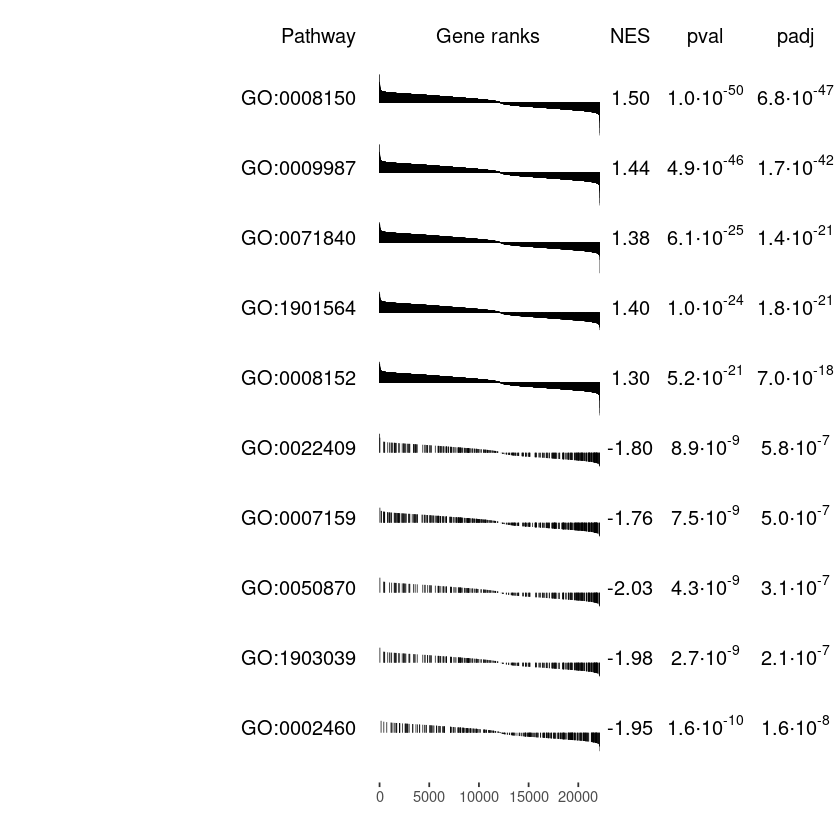

In [31]:
# select the top five up-regulated pathways 
topPathwaysUp <- fgsea_result[ES > 0][head(order(pval), n = 5), pathway]
# select the top five down-regulated pathways 
topPathwaysDown <- fgsea_result[ES < 0][head(order(pval), n = 5), pathway]
# concatenate them for visualization
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(pathways = GO_term_hallmark[topPathways], stats = stats, 
              fgseaRes = fgsea_result, gseaParam = 0.5)

To use the `plotGseaTable` function, we need to pass the following arguments:

- `pathways`: A list of pathways to plot table.
- `stats`: A dataframe specifying gene-level stats.
- `fgseaRes`: A dataframe of fgsea results.
- `gseaParam`: A numeric value to adjust displayed statistic values, values closer to 0 flatten plots. Default = 1, value of 0.5 is a good choice too.

### Enrichment analysis using FGSEA and KEGG pathways
We can perform enrichment analysis using FGSEA with KEGG pathway using the same procedure mentioned above. The only thing we need to change is the
list of gene sets that are available in the KEGG database.

In [32]:
# Load the pathways into a named list
KEGG_hallmark <- gmtPathways("./data/KEGG_pathways.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(KEGG_hallmark, head)
tmp[1:5]

$hsa00010
[1] "HK3"   "HK1"   "HK2"   "HKDC1" "GCK"   "GPI"  

$hsa00020
[1] "CS"   "ACLY" "ACO2" "ACO1" "IDH1" "IDH2"

$hsa00030
[1] "GPI"  "G6PD" "PGLS" "H6PD" "PGD"  "RPE" 

$hsa00040
[1] "GUSB"    "KL"      "UGT2A1"  "UGT2A3"  "UGT2B17" "UGT2B11"

$hsa00051
[1] "MPI"   "PMM2"  "PMM1"  "GMPPB" "GMPPA" "GMDS"

In [33]:
# Running fgsea analysis
geneset <- KEGG_hallmark
fgsea_output <- runFgsea(DE_data = DE.df, genesets = geneset)
# Get result and stats from output of runFgsea function
fgsea_result <- fgsea_output$fgsea_res
stats <- fgsea_output$stats

head(fgsea_result[order(fgsea_result$p.value), c("ID", "p.value", "score", "normalizedScore")])

ID,p.value,score,normalizedScore
<chr>,<dbl>,<dbl>,<dbl>
hsa05022,5.605248e-27,0.5151351,2.223921
hsa05016,1.139118e-22,0.5530733,2.324762
hsa05010,4.790402e-22,0.5186173,2.224995
hsa05012,1.183023e-21,0.5612790,2.339341
hsa05020,1.857486e-20,0.5561393,2.324162
hsa00190,1.925488e-20,0.6624476,2.602736


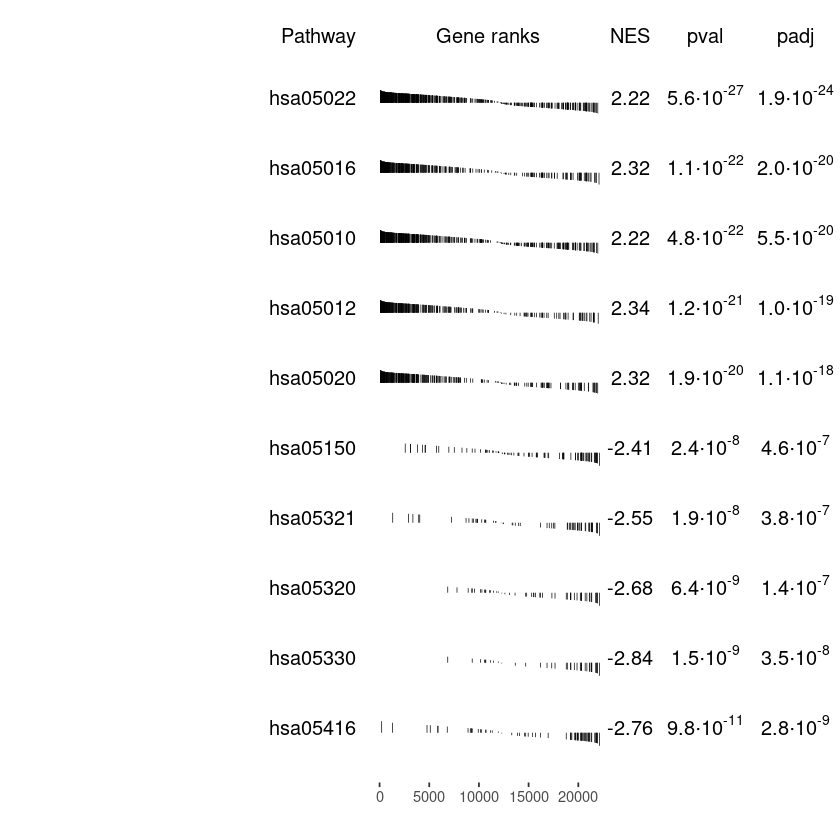

In [34]:
# select the top five up-regulated pathways 
topPathwaysUp <- fgsea_result[ES > 0][head(order(pval), n = 5), pathway]
# select the top five down-regulated pathways 
topPathwaysDown <- fgsea_result[ES < 0][head(order(pval), n = 5), pathway]
# concatenate them for visualization
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(pathways = KEGG_hallmark[topPathways], stats = stats, 
              fgseaRes = fgsea_result, gseaParam = 0.5)

### Enrichment analysis using FGSEA and REACTOME pathways
We can perform enrichment analysis using FGSEA with REACTOME pathways using the same procedure above. 

In [35]:
# Load the pathways into a named list
REACTOME_hallmark <- gmtPathways("./data/REACTOME_pathways.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(REACTOME_hallmark, head)
tmp[1:5]

$`R-HSA-15869`
[1] "RRM1" "RR1"  "RRM2" "RR2"  "GLRX" "GRX" 

$`R-HSA-68616`
[1] "ORC1"  "ORC1L" "PARC1" "H4C1"  "H4/A"  "H4FA" 

$`R-HSA-68689`
[1] "ORC1"  "ORC1L" "PARC1" "ORC4"  "ORC4L" "ORC5" 

$`R-HSA-68867`
[1] "ORC1"  "ORC1L" "PARC1" "ORC4"  "ORC4L" "ORC5" 

$`R-HSA-68875`
[1] "PLK1"    "PLK"     "GOLGA2"  "GORASP1" "GOLPH5"  "GRASP65"

In [36]:
# Running fgsea analysis
geneset <- REACTOME_hallmark
fgsea_output <- runFgsea(DE_data = DE.df, genesets = geneset)
# Get result and stats from output of runFgsea function
fgsea_result <- fgsea_output$fgsea_res
stats <- fgsea_output$stats

head(fgsea_result[order(fgsea_result$p.value), c("ID", "p.value", "score", "normalizedScore")])

ID,p.value,score,normalizedScore
<chr>,<dbl>,<dbl>,<dbl>
R-HSA-1428517,1.981813e-23,0.6390720,2.582488
R-HSA-163200,9.732023e-21,0.6775255,2.635396
R-HSA-611105,4.059348e-20,0.7057548,2.684476
R-HSA-392499,1.850821e-19,0.3509028,1.560990
R-HSA-112316,1.889122e-17,0.4740030,2.041866
R-HSA-5368287,3.006443e-15,0.6542727,2.473694


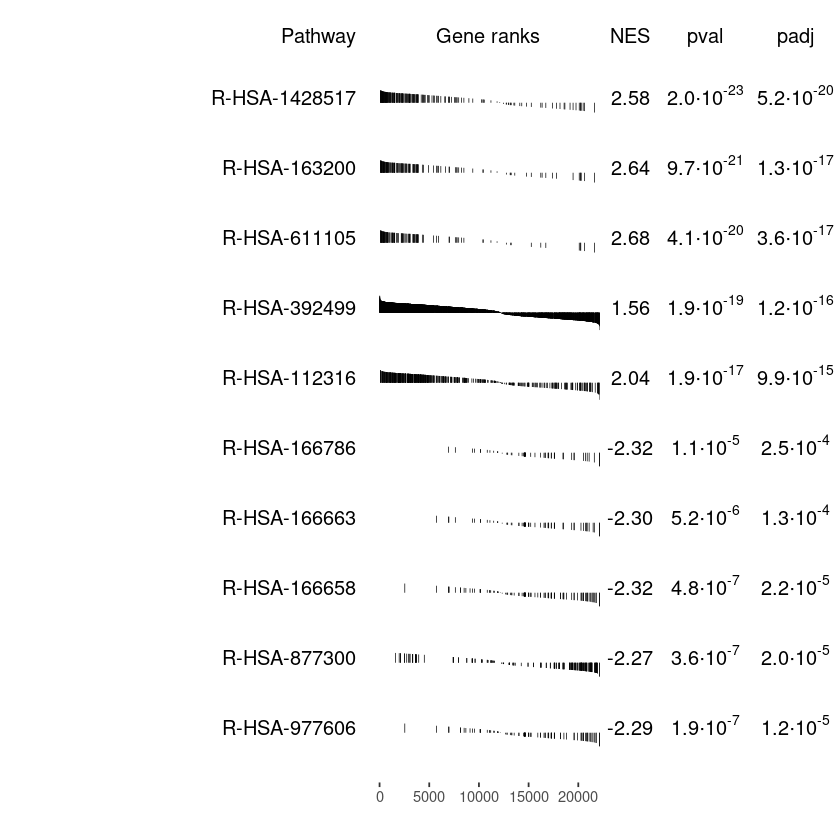

In [37]:
# select the top five up-regulated pathways 
topPathwaysUp <- fgsea_result[ES > 0][head(order(pval), n = 5), pathway]
# select the top five down-regulated pathways 
topPathwaysDown <- fgsea_result[ES < 0][head(order(pval), n = 5), pathway]
# concatenate them for visualization
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(pathways = REACTOME_hallmark[topPathways], stats = stats, 
              fgseaRes = fgsea_result, gseaParam = 0.5)

## Gene Set Enrichment Analysis using GSA

Gene Set Analysis (GSA), an Enrichment Analysis, is a method that is commonly used to summarize high-dimensional gene expression data sets into sets according to their biological relevance. GSA takes the ranked gene lists from the initial stage of a gene expression analysis and aggregates the genes into sets based on shared biological or functional properties as specified by a reference knowledge base. Such databases often contain phenotype associations, molecular interactions and regulation and are referenced in the analysis of the resultant gene sets to find the relevance of the gene properties to the phenotype of interest.

In [38]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-4.html" width=100% height=250></iframe>')

### Data preparation
The GSA method is freely available as standalone package in CRAN repository. We can use the following code to install the package.

In [5]:
# Install GSA from CRAN
suppressMessages({
    suppressWarnings({
        if (!require("GSA")) install.packages("GSA")
    })
})

suppressMessages({
    suppressWarnings({
        library(GSA)
    })
})

In [40]:
#' @description This function performs enrichment analysis using the GSA method.
#'
#' @param exprsData Numeric matrix or matrix-like object containing gene expression data. Rows represent genes, columns represent samples.
#' @param genesets List of gene sets for pathway analysis.
#' @param groups Factor indicating sample groups.
#' @param nperms Number of permutations for assessing significance (default is 100).
#'
#' @return A list containing the GSA results data frame and the GSA object.

runGSA <- function(exprsData, genesets, groups, nperms = 100) {
    # Determine the number of classes in the group variable
    num_classes <- length(unique(groups))
    resp_type <- NULL

    # Check the number of classes and set response type accordingly
    if (num_classes == 1) {
        stop("The group classes in the design matrix must be at least two.")
    } else if (num_classes == 2) {
        resp_type <- "Two class unpaired"
    } else {
        resp_type <- "Multiclass"
    }

    # Run GSA analysis
    gsa_res <- GSA::GSA(
        x = exprsData,
        y = groups,
        genesets = genesets,
        resp.type = resp_type,
        genenames = rownames(exprsData),
        nperms = nperms
    )

    # Extract p-values and create result data frame
    pvalues <- apply(cbind(gsa_res$pvalues.lo, gsa_res$pvalues.hi), 1, min)
    res <- data.frame(ID = names(genesets), p.value = pvalues * 2, stringsAsFactors = FALSE)

    # Create GSA result data frame
    GSA_res <- data.frame(
        ID = res$ID,
        p.value = res$p.value,
        score = gsa_res$GSA.scores,
        normalizedScore = gsa_res$GSA.scores,
        stringsAsFactors = FALSE
    )

    # Return a list containing GSA results
    list(GSA_res = GSA_res[!is.na(GSA_res$p.value), ], GSA.obj = gsa_res)
}


The GSA method requires an expression matrix, a numeric vector containing the class of each sample and a vector of the genes inputs. We can easily get those inputs by loading the data that we processed in the [**submodule 01** ](./Module01-GEO_Data_Processing.ipynb). From the samples information, we can use the same code in [**submodule 02** ](./Module02-DE_Analysis.ipynb) to create the groups information factor.

In [41]:
# Loading expression data and samples information
expression_data <- data$expression_data
norm_expression_data <- data$norm_expression_data
samples <- data$samples


Get the groups information for GSA function.

In [42]:
# Select disease samples
disease_idx <- grep("AD", samples$source_name_ch1)
# Create a vector to store the label
groups <- rep("X", nrow(samples))
# Annotate disease samples as "d"
groups[disease_idx] <- "d"
# Control samples are labeled as "c"
groups[which(groups != "d")] <- "c"
groups <- factor(groups)
groups

[1] c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c
[39] c d d d d d d d d d d d d d d d
Levels: c d

We can also use the same approach to map the probe IDs to symbols using the `map_identifiers` function above and the annotLookup table saved in [**submodule 01** ](./Module01-GEO_Data_Processing.ipynb). The step-by-step coding instruction is shown below:

In [43]:
# Assign a new variable for expression data and create a PROBEID column 
new_expression_data <- norm_expression_data
new_expression_data$PROBEID <- rownames(new_expression_data) 
# Map all the probe id to symbols
new_expression_data <- map_identifiers(data_df = new_expression_data, mapping_df = annotLookup, 
                                       data_source_col = "PROBEID", data_target_col ="SYMBOL", data_result_col = NULL)
# Remove the PROBEID, GENENAME, SYMBOL columns
new_expression_data <- new_expression_data[, !(names(new_expression_data) %in% colnames(annotLookup))]
# Create a list of gene names for the GSA function
genenames <- rownames(new_expression_data)

head(new_expression_data)


,GSM300173,GSM300177,GSM300181,GSM300186,GSM300189,GSM300192,GSM300196,GSM300204,GSM300208,GSM300214,⋯,GSM1176201,GSM1176202,GSM1176203,GSM1176204,GSM1176205,GSM1176206,GSM1176207,GSM1176208,GSM1176209,GSM1176210
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDR1,0.6085351,0.8513945,1.1591995,2.0921063,1.2385797,0.8326798,0.8034588,0.6996407,1.3955209,1.1198790,⋯,1.1563261,1.6152382,1.1901788,1.4972300,0.6329609,1.4160284,1.2335104,1.2999401,0.8595833,1.2998189
RFC2,0.9081397,0.9336113,0.8563885,1.0015364,0.7332213,0.8570584,1.0210657,0.9641521,0.8585522,0.8584299,⋯,0.8848516,0.9385835,1.0359085,0.9225201,1.0405487,0.8187565,0.9541863,0.9855680,1.1704986,0.9924505
HSPA6,0.8674964,0.8385732,0.9956165,0.9797408,3.5688195,1.0145685,1.1729818,1.0208826,0.8163447,0.8572931,⋯,0.9469172,1.3414407,0.9509885,1.3277143,1.0712911,0.9801153,0.9847162,1.4585433,1.2102244,0.9023996
PAX8,1.1053528,1.0432043,1.0137772,1.0931698,1.0356631,0.9435998,1.1165266,1.0960624,1.0099041,1.0553276,⋯,1.0055602,0.8999849,0.9461904,1.2250262,1.0535747,0.9321033,1.0115234,1.0048561,1.1175232,1.0730404
GUCA1A,1.2764652,0.8625501,1.0411838,1.0323309,0.8504494,1.3334491,1.1356378,1.0168769,0.9045680,0.8634836,⋯,1.3178803,0.8809971,0.9128050,1.0231747,1.0368457,0.9140167,1.0870208,0.9601511,3.4069852,1.0806457
UBA7,0.8337133,1.0081274,1.0330204,1.5409547,0.8751729,1.0063332,0.7226255,0.9519509,0.8132348,1.0214182,⋯,1.2466778,1.8324052,0.8732074,1.4028883,0.9107665,0.9586981,1.1221024,1.1861940,1.0770138,1.2797908


### Enrichment Analysis using GSA and GO Terms
Using data obtained from the previous step, we can run the GSA method by calling the function `GSA`. We can reuse `GO_term_hallmark` and `KEGG_hallmark` loaded in FGSEA to perform analysis. The code details are shown below:

In [44]:
genesets <- GO_term_hallmark
GSA_output <- runGSA(as.matrix(new_expression_data), genesets = genesets, as.numeric(groups), nperms = 1000)
# Get GSA_result dataframe and GSA object from output of the runGSA function
GSA_result <- GSA_output$GSA_res
GSA.obj <- GSA_output$GSA.obj

perm= 10 / 200 
perm= 20 / 200 
perm= 30 / 200 
perm= 40 / 200 
perm= 50 / 200 
perm= 60 / 200 
perm= 70 / 200 
perm= 80 / 200 
perm= 90 / 200 
perm= 100 / 200 
perm= 110 / 200 
perm= 120 / 200 
perm= 130 / 200 
perm= 140 / 200 
perm= 150 / 200 
perm= 160 / 200 
perm= 170 / 200 
perm= 180 / 200 
perm= 190 / 200 
perm= 200 / 200 


In [45]:
head(GSA_result[order(GSA_result$p.value), ])

,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
976,GO:0007007,0,-1.2667252,-1.2667252
1117,GO:0007422,0,0.5244847,0.5244847
1131,GO:0007528,0,-0.5348092,-0.5348092
1222,GO:0008535,0,0.8557904,0.8557904
1348,GO:0009301,0,-0.6456349,-0.6456349
1681,GO:0014037,0,1.0558858,1.0558858


<div class="alert alert-block alert-danger">
    <i class="fa fa-exclamation-circle" aria-hidden="true"></i>
    <b>Alert: </b>  Please note that the outputs generated from GSA can be varied depending on R environments and software versions. Especially, when the users run the scripts using User-managed Notebooks instances which have a preinstalled suite of packages.
</div>

From the analysis result, we can now get the list positive and negative genes of the GSA analysis from the GSA object using the `GSA.listsets` function. 

In [46]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

To use the `GSA.listsets` function, we need to pass the following arguments:

- `GSA.obj`: A GSA object returned by GSA function.
- `geneset.names`: An optional vector of names for the gene sets.
- `FDRcut`: A numeric value specifying the false discovery rate cutpoint for listed sets. A value of 1 will cause all sets to be listed.

The `GSA.listsets` function returns a list of the results from the GSA call.

A table of the negative gene sets. “Negative” means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. E.g., for two classes coded 1,2, lower expression correlates with class 2.

In [47]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
976,GO:0007007,-1.2667,0,0
1131,GO:0007528,-0.5348,0,0
1348,GO:0009301,-0.6456,0,0
1896,GO:0018198,-0.5918,0,0
2373,GO:0031398,-0.3619,0,0
2405,GO:0031647,-0.2946,0,0


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y.

In [48]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
1117,GO:0007422,0.5245,0,0
1222,GO:0008535,0.8558,0,0
1681,GO:0014037,1.0559,0,0
1682,GO:0014044,1.3361,0,0
1877,GO:0017145,0.5377,0,0
2009,GO:0021533,1.0827,0,0


In [49]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, 
               GSA.obj = GSA.obj, genenames = genenames)

Gene,Score
SH3GLB1,2.814
IFT88,2.468
TP53INP1,2.353
MTMR3,2.168
ATG16L2,1.947
ATG14,1.908
ATG2B,1.789
ATG7,1.648
NUPR1,1.578
MAP1LC3B2,1.311


To use the `GSA.genescores` function, we need to pass the following arguments:

- `geneset.number`: A number specifying which gene set is to be examined.
- `genesets`: A list containing the gene set collection.
- `GSA.obj`: A GSA object returned by the GSA function.
- `genenames`: A vector containing gene names for genes in the expression dataset.

The `GSA.genescores` returns a matrix of gene names and gene scores (eg t-statistics) for each gene in the gene set.


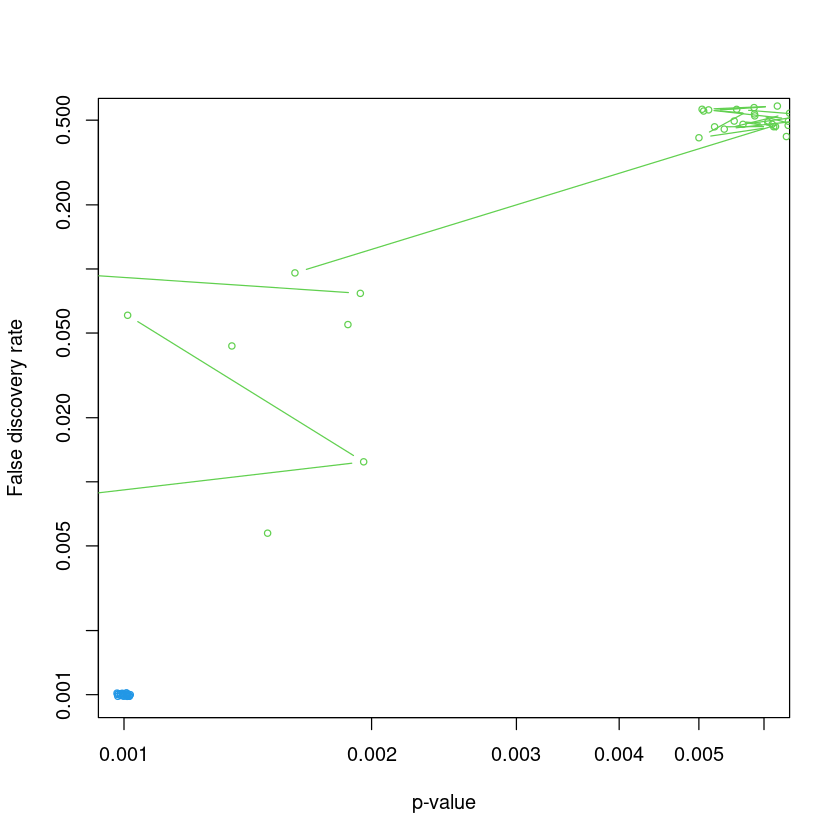

In [50]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac = 1, FDRcut = 0.5))

To use the `GSA.plot` function, we need to pass the following arguments:

- `GSA.obj`: A GSA object returned by the GSA function.
- `fac`: A numeric value for jittering points in plot ("factor" in called to jitter()).
- `FDRcut`: A numeric value specifying the false discovery rate cutpoint for sets to be plotted. A value of 1 (the default) will cause all sets to be plotted.



### Enrichment analysis using GSA and KEGG pathways
We can use the same procedure to per enrichment analysis with the KEGG pathway. All the codes are similar but `genesets` are assigned from `KEGG_hallmark`. The code is shown below.

In [51]:
genesets <- KEGG_hallmark
GSA_output <- runGSA(as.matrix(new_expression_data), genesets = genesets, as.numeric(groups), nperms = 1000)
# Get GSA_result dataframe and GSA object from output of the runGSA function
GSA_result <- GSA_output$GSA_res
GSA.obj <- GSA_output$GSA.obj

perm= 10 / 200 
perm= 20 / 200 
perm= 30 / 200 
perm= 40 / 200 
perm= 50 / 200 
perm= 60 / 200 
perm= 70 / 200 
perm= 80 / 200 
perm= 90 / 200 
perm= 100 / 200 
perm= 110 / 200 
perm= 120 / 200 
perm= 130 / 200 
perm= 140 / 200 
perm= 150 / 200 
perm= 160 / 200 
perm= 170 / 200 
perm= 180 / 200 
perm= 190 / 200 
perm= 200 / 200 


In [52]:
head(GSA_result[order(GSA_result$p.value), ])

,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
15,hsa00190,0,-1.0618901,-1.0618901
164,hsa04520,0,0.4226582,0.4226582
169,hsa04810,0,0.2382996,0.2382996
182,hsa04658,0,0.4834651,0.4834651
214,hsa04260,0,-0.6794162,-0.6794162
239,hsa04723,0,-0.7124414,-0.7124414


In [53]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

A table of the negative gene sets. "Negative" means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. E.g., for two classes coded 1,2, lower expression correlates with class 2.

In [54]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
15,hsa00190,-1.0619,0,0
214,hsa04260,-0.6794,0,0
239,hsa04723,-0.7124,0,0
252,hsa04714,-0.5351,0,0
259,hsa05208,-0.4709,0,0
318,hsa05010,-0.5043,0,0


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [55]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
164,hsa04520,0.4227,0,0
169,hsa04810,0.2383,0,0
182,hsa04658,0.4835,0,0
336,hsa05416,0.8498,0.005,0.4038
146,hsa04514,0.3784,0.01,0.4405
170,hsa04640,0.6098,0.01,0.4405


In [56]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, 
               GSA.obj = GSA.obj, genenames = genenames)

Gene,Score
ALDH9A1,2.825
ACSS1,2.499
ADH1B,1.97
GRHPR,1.02
ALDH7A1,0.977
ALDH2,0.86
ALDH3A2,0.762
ACACB,0.515
ADH6,0.341
LDHAL6B,0.215


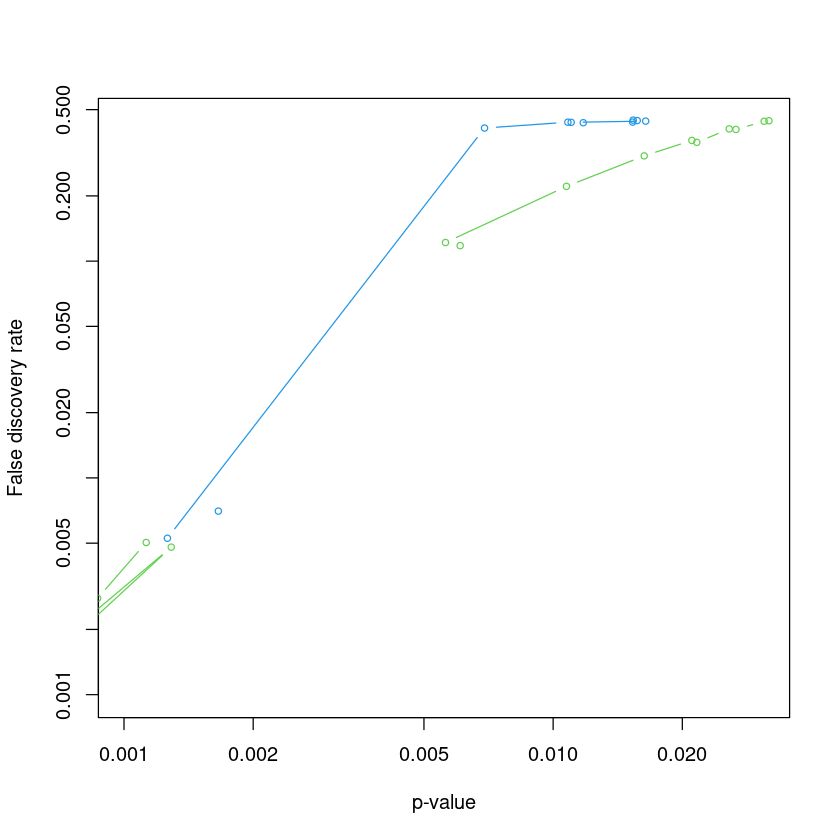

In [57]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac = 1, FDRcut = 0.5))


### Enrichment analysis using GSA and REACTOME pathways
We can use the same procedure to per enrichment analysis with the REACTOME pathway. All the codes are similar but `genesets` are assigned from `REACTOME_hallmark`. The code is shown below.

In [58]:
genesets <- REACTOME_hallmark
GSA_output <- runGSA(as.matrix(new_expression_data), genesets = genesets, as.numeric(groups), nperms = 1000)
# Get GSA_result dataframe and GSA object from output of the runGSA function
GSA_result <- GSA_output$GSA_res
GSA.obj <- GSA_output$GSA.obj

perm= 10 / 200 
perm= 20 / 200 
perm= 30 / 200 
perm= 40 / 200 
perm= 50 / 200 
perm= 60 / 200 
perm= 70 / 200 
perm= 80 / 200 
perm= 90 / 200 
perm= 100 / 200 
perm= 110 / 200 
perm= 120 / 200 
perm= 130 / 200 
perm= 140 / 200 
perm= 150 / 200 
perm= 160 / 200 
perm= 170 / 200 
perm= 180 / 200 
perm= 190 / 200 
perm= 200 / 200 


In [59]:
head(GSA_result[order(GSA_result$p.value), ])


,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
477,R-HSA-186712,0,1.3126050,1.3126050
612,R-HSA-210744,0,3.6748999,3.6748999
615,R-HSA-210747,0,5.5610582,5.5610582
954,R-HSA-917937,0,-0.3787052,-0.3787052
1242,R-HSA-2173789,0,0.5020329,0.5020329
1509,R-HSA-5205647,0,-0.7770558,-0.7770558


In [60]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

In [61]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
954,R-HSA-917937,-0.3787,0,0
1509,R-HSA-5205647,-0.7771,0,0
2075,R-HSA-8949215,-0.9537,0,0
2078,R-HSA-8949664,-0.8861,0,0


In [62]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
477,R-HSA-186712,1.3126,0,0
612,R-HSA-210744,3.6749,0,0
615,R-HSA-210747,5.5611,0,0
1242,R-HSA-2173789,0.502,0,0
2527,R-HSA-9708296,1.3313,0,0


In [63]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, 
               GSA.obj = GSA.obj, genenames = genenames)

Gene,Score
SMC1A,2.971
CEP131,2.834
STAG2,2.768
STAG1,2.698
NUP188,2.654
NUP107,2.618
H3-3B,2.471
NINL,2.406
HAUS8,2.351
CAPG,2.235


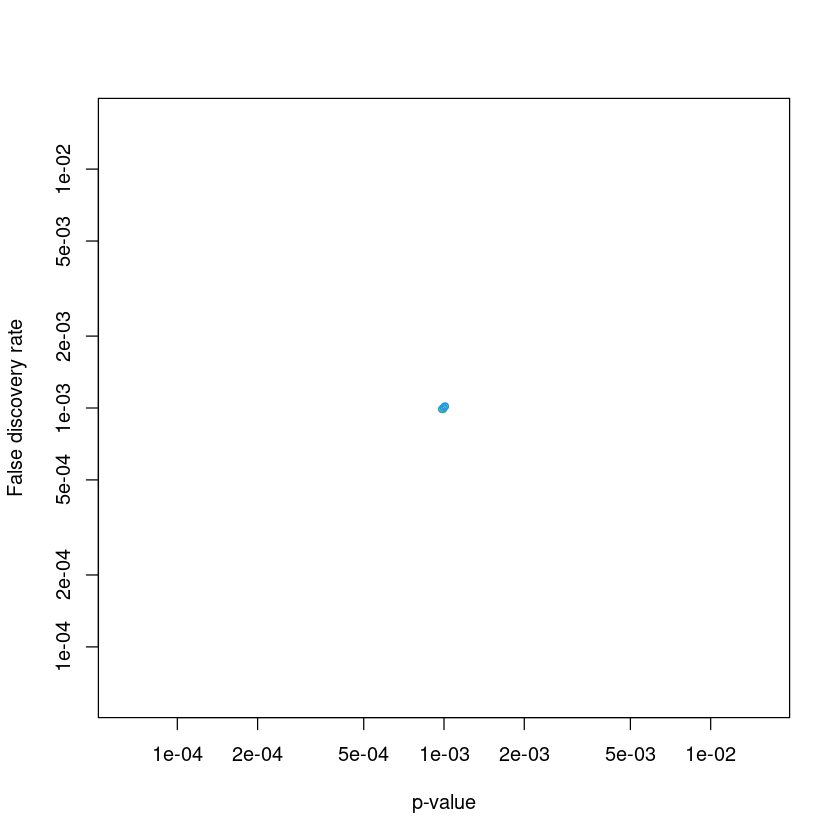

In [64]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac = 1, FDRcut = 0.5))


# Enrichment analysis using PADOG

Pathway Analysis with Down-weighting of Overlapping Genes (PADOG) is a specialized method for enrichment analysis. Focused on deciphering the functional implications of differentially expressed genes in biological pathways, PADOG uniquely emphasizes the uniqueness of genes. Its down-weighting mechanism enhances precision by addressing challenges posed by overlapping genes, offering valuable insights into specific pathways influenced by gene expression changes.

To perform PADOG enrichment analysis, we will use the "PADOG" package. We first need to install and load the package.

In [65]:
suppressWarnings({
    suppressMessages({
        if (!require("BiocManager", quietly = TRUE)) {
            install.packages("BiocManager")
        }
        BiocManager::install("PADOG")
    })
})

suppressWarnings({suppressMessages({library(PADOG)})})


We will use the `runPadog` function below to perform enrichment analysis using `PADOG` package. This function requires a normalized expression matrix, a list of gene sets to analyze and the group information of the dataset. It will return the analysis results in a dataframe.

In [66]:
#' @description This function performs enrichment analysis using the PADOG method.
#'
#' @param exprsData Numeric matrix or matrix-like object containing gene expression data. Rows represent genes, columns represent samples.
#' @param geneSet List of gene sets for pathway analysis.
#' @param groups Factor indicating sample groups.
#' @param perm Number of permutations for assessing significance (default is 100).
#' @param seed Seed for reproducibility of permutation results (default is 1).
#' @param ncore Number of cores to use for parallel processing (default is 1).
#'
#' @return A data frame containing pathway IDs and corresponding p-values.

runPadog <- function(exprsData, geneSet, groups, perm = 100, seed = 1, ncore = 1) {
    # Run PADOG analysis
    res <- PADOG::padog(
        esetm = as.matrix(exprsData),
        group = groups,
        gslist = geneSet,
        annotation = NULL,
        gs.names = names(geneSet),
        NI = perm,
        plots = FALSE,
        targetgs = NULL,
        dseed = seed,
        parallel = TRUE,
        ncr = ncore
    )
    # Extract relevant columns and rename
    res <- res[, c('ID', 'Ppadog')]
    colnames(res) <- c("pathway", "p.value")
    
    return(res)
}


## Data Preparation

The PADOG method requires inputs that are quite similar to the GSA method. Thus, to perform analysis using PADOG, we will use the previously preprocessed `new_expression_data` dataframe and `groups` information for the GSA method above.

### Enrichment analysis using PADOG and GO terms

In [67]:
# Assign the geneset variable to GO_term_hallmark loaded in previous code
geneset <- GO_term_hallmark
# Perform PADOG enrichment analysis using the runPadog function
PADOG_result <- runPadog(exprsData = new_expression_data, geneSet = geneset, 
                         groups = groups, perm = 1000, seed = 1, ncore = 1)

head(PADOG_result)

Starting with 6909 gene sets!
Analyzing 6909 gene sets with 3 or more genes!
# of permutations used: 100 
[1] "Name"      "ID"        "Size"      "meanAbsT0" "padog0"    "PmeanAbsT"
[7] "Ppadog"   


,pathway,p.value
,<chr>,<dbl>
GO:0065003,GO:0065003,1e-04
GO:0007005,GO:0007005,1e-04
GO:0042773,GO:0042773,1e-04
GO:0042775,GO:0042775,1e-04
GO:0007007,GO:0007007,1e-04
GO:0042407,GO:0042407,1e-04


### Enrichment analysis using PADOG and KEGG pathways

We can use the same procedure to perform enrichment analysis with the GO terms. All the codes are similar but the gene sets list is loaded from `KEGG`. The code is shown below.

In [68]:
# Assign the geneset variable to KEGG_hallmark loaded in previous code
geneset <- KEGG_hallmark
# Perform PADOG enrichment analysis using the runPadog function
PADOG_result <- runPadog(exprsData = new_expression_data, geneSet = geneset, 
                         groups = groups, perm = 1000, seed = 1, ncore = 1)

head(PADOG_result)

Starting with 344 gene sets!
Analyzing 344 gene sets with 3 or more genes!
# of permutations used: 100 
[1] "Name"      "ID"        "Size"      "meanAbsT0" "padog0"    "PmeanAbsT"
[7] "Ppadog"   


,pathway,p.value
,<chr>,<dbl>
hsa05016,hsa05016,1e-04
hsa05022,hsa05022,1e-04
hsa05012,hsa05012,1e-04
hsa00190,hsa00190,1e-04
hsa05020,hsa05020,1e-04
hsa05010,hsa05010,1e-04


### Enrichment analysis using PADOG and REACTOME pathways

We will apply the same code that has been used for the GO terms and KEGG pathways.

In [69]:
# Assign the geneset variable to KEGG_hallmark loaded in previous code
geneset <- REACTOME_hallmark
# Perform PADOG enrichment analysis using the runPadog function
PADOG_result <- runPadog(exprsData = new_expression_data, geneSet = geneset, 
                         groups = groups, perm = 1000, seed = 1, ncore = 1)

head(PADOG_result)

Starting with 2673 gene sets!
Analyzing 2234 gene sets with 3 or more genes!
# of permutations used: 100 
[1] "Name"      "ID"        "Size"      "meanAbsT0" "padog0"    "PmeanAbsT"
[7] "Ppadog"   


,pathway,p.value
,<chr>,<dbl>
R-HSA-210747,R-HSA-210747,1e-04
R-HSA-1428517,R-HSA-1428517,1e-04
R-HSA-210744,R-HSA-210744,1e-04
R-HSA-444411,R-HSA-444411,1e-04
R-HSA-1852241,R-HSA-1852241,1e-04
R-HSA-5617833,R-HSA-5617833,1e-04


The next submodule will go indepth about meta analysis.

In [70]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.13.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] PADOG_1.44.0             Biobase_2.62.0           BiocGenerics_0.48.1     
[4] KEGGdzPathwaysGEO_1.40.0 GSA_1.03.2               fgsea_1.28.0            
[7] BiocManager_1.30.22     

loaded via a namespace (and n